In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.discriminant_analysis import StandardScaler
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from keras.models import Model
from keras.layers import Activation, Dense, LSTM, Input
from keras.optimizers import Adam, RMSprop, SGD
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from os import path

Method to load the dataset

In [42]:
def load_dataset(columns_drop) -> tuple([pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]):
    train = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\train.csv")
    greeks = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\greeks.csv")
    test = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\test.csv")
    """
    train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
    greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
    test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
    """
    columns_drop = ['Id'] + columns_drop
    id_list = test["Id"]
    train.drop(columns_drop, inplace=True, axis=1)
    test.drop(columns_drop, inplace=True, axis=1)
    print(len(train.columns))
    return (train, greeks, test, id_list)

Method to split the data in validation and train set randomly

In [43]:
def split_data(df: pd.DataFrame, split)->tuple([pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]):
    X = df.loc[:, df.columns != "Class"]
    y = df.loc[:, "Class"]
    return train_test_split(X, y, test_size=split, random_state=42)

Method to build a Tensorflow model

In [44]:
def build_tensorflow_model(input_shape:int, output_shape:int, units1: int, units2: int, units3: int, units4: int, activation1: str, 
                activation2: str, activation3: str, activation4: str, optimizer: tf.keras.optimizers.Optimizer, learning_rate: float) -> Model:
    input = Input(shape=input_shape)
    x = Dense(units=units1, activation=activation1)(input)
    x = Dense(units=units2, activation=activation2)(x)
    x = Dense(units=units3, activation=activation3)(x)
    x = Dense(units=units4, activation=activation4)(x)
    output = Dense(units=output_shape, activation="softmax")(x)
    model = Model(inputs=[input], outputs=[output])
    
    model.compile(loss="categorical_crossentropy",
              optimizer=optimizer(learning_rate=learning_rate),
              metrics=["accuracy"])   
    return model

Method to plot the accuracy of the model

In [45]:
def plot_acc_tf_model(history:Model):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Method to fit the Tensorflow model with ES Callback

In [46]:
es_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=1,
        restore_best_weights=True,
        min_delta=0.005
    )
 
def fit_model(model: Model, x: np.ndarray, y: np.ndarray, epochs: int, split: float) -> Model:
    #split train and validation
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=split, random_state=42)
    #fit the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val,y_val), callbacks=[es_callback])
    return history 

Method to build a preprocessing pipeline

In [47]:
def build_preprocessing_pipeline(df: pd.DataFrame) -> ColumnTransformer:
    # Preprocessing for numerical data    
    numerical_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant')),
        ('scaler', StandardScaler())])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Bundle preprocessing for numerical and categorical data
    numerical_cols = [cname for cname in df.columns if df[cname].dtype in ["int64", "float64"]]
    categorical_cols = [cname for cname in df.columns if df[cname].nunique() < 10]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    print(f"Number of columns: {len(df.columns)}")
    return preprocessor

Create a model and preprocessor

36
dataset shape: (617, 36)
Number of columns: 35
Epoch 1/100
11/11 [==============================] - 1s 17ms/step - loss: 0.6332 - accuracy: 0.7616 - val_loss: 0.5207 - val_accuracy: 0.8391
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5131 - accuracy: 0.8372 - val_loss: 0.4679 - val_accuracy: 0.8391
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.4392 - accuracy: 0.8372 - val_loss: 0.4429 - val_accuracy: 0.8391
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3799 - accuracy: 0.8459 - val_loss: 0.4251 - val_accuracy: 0.8391
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8808 - val_loss: 0.4181 - val_accuracy: 0.8391
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2810 - accuracy: 0.8924 - val_loss: 0.4152 - val_accuracy: 0.8391
Epoch 6: early stopping


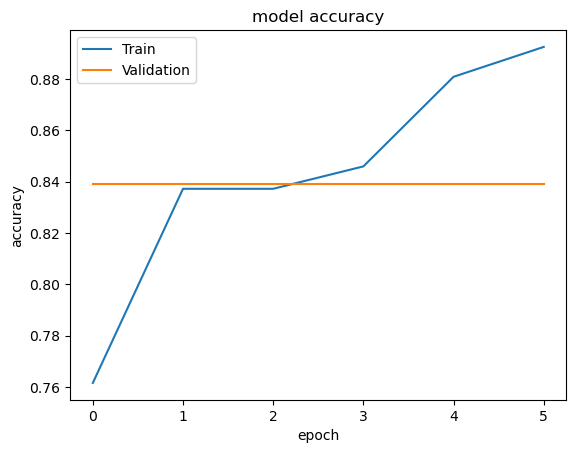

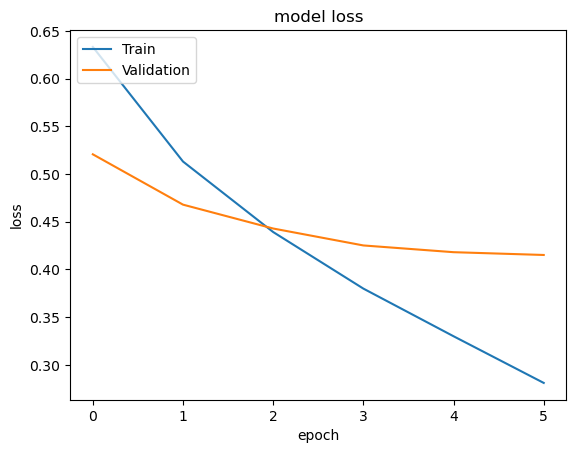

In [48]:
#Newly load the dataset with columns drop and create preprocessing pipeline
bad_col = ['CH', 'CC', 'DN', 'CW ', 'EG', 'CU', 'CF', 'CB', 'DV', 'AH', 'AY', 'GB', 'FS', 'AZ', 'DE', 'DY', 'BD ', 'FD ', 'CD ', 'BZ', 'EL']
train, greeks, test, id_list = load_dataset(columns_drop=bad_col)
print(f"dataset shape: {train.shape}")
X_train, X_valid, y_train, y_valid = split_data(train, 0.3)
preprocessor = build_preprocessing_pipeline(X_train)


# Define models for the pipeline
preprocessor.fit(X_train)
X_preprocessed = preprocessor.transform(X_train)
y_train_ohe = pd.get_dummies(y_train, columns = ['Class'])
y_valid_ohe = pd.get_dummies(y_valid, columns = ['Class'])
model_keras = build_tensorflow_model(input_shape=len(X_preprocessed[1]), output_shape=2, units1=16, units2=32, units3=64, units4=128,activation1="relu",
                                     activation2="relu", activation3="relu", activation4="relu", optimizer=Adam, learning_rate=0.001)
history = fit_model(model_keras, X_preprocessed, y_train_ohe, 100, 0.2)
plot_acc_tf_model(history)
model_keras = KerasClassifier(model=model_keras, epochs=0)
model_rf = RandomForestClassifier(n_estimators=100, random_state=22)
model_xgb = XGBClassifier(n_estimators=500)

Build the final pipeline with preprocessor and model, fit it and display accuracy score

In [49]:
# Building Pipeline
def fit_pipeline(X_train: pd.DataFrame, y_train: pd.DataFrame, preprocessor, model) -> Pipeline:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                            ])
    #Fit the Model and make preds
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)
    """ score = cross_val_score(pipeline, X_valid, y_valid, cv=5, scoring='accuracy')
    print(f"Accuracy of {score}") """
    correct_answers = 0
    for y_pred,y_true in zip(preds,y_valid_ohe.to_numpy()):
        if(y_pred[0] == y_true[0]):correct_answers+=1
    print(correct_answers/len(preds))
    return pipeline

Print results of the model

In [50]:
pipeline_keras = fit_pipeline(X_train, y_train_ohe, preprocessor, model_keras)
pipeline_rf = fit_pipeline(X_train, y_train_ohe, preprocessor, model_rf)
pipeline_xgb = fit_pipeline(X_train, y_train_ohe, preprocessor, model_xgb)

6/6 [==============================] - 0s 998us/step
0.7956989247311828
0.9354838709677419
0.946236559139785


Combine the fitted models to look if the accuracy improves

In [51]:
preds1 = pipeline_keras.predict(test)
preds2 = pipeline_rf.predict(test)
preds3 = pipeline_xgb.predict(test)
submission = [[0,0] for _ in range(len(preds1))]
for y_pred1,y_pred2,y_pred3, i in zip(preds1,preds2,preds3, range(len(preds1))):
    count_class1 = y_pred1[0] + y_pred2[0] + y_pred3[0]
    count_class2 = y_pred1[1] + y_pred2[1] + y_pred3[1]
    submission[i][0] = round(count_class1/(count_class1 + count_class2),2)
    submission[i][1] = round(count_class2/(count_class1 + count_class2),2)

1/1 [==============================] - 0s 24ms/step


Submission

In [52]:
submission_df = pd.DataFrame()
submission_df.insert(0, "Id", id_list, False)
submission_df.insert(1, "class_0", [i[0] for i in submission], True)
submission_df.insert(2, "class_1", [i[1] for i in submission], True)
submission_df.to_csv("C:\Projects\kaggle\competitions\identify-age-related-conditions\submissions\submission.csv",index = False)
#submission_df.to_csv("/kaggle/working/submission.csv",index = False)

5
